In [1]:
import netCDF4
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import models.segmentation_models_qubvel as sm
from utils.augmentation import get_preprocessing
from utils.smooth_tiled_predictions import predict_img_with_smooth_windowing

: 

: 

In [ ]:
def visualize_ir(img, idx=None, cmap='cividis', colorbar=False, save_path=None):
    plt.imshow(img, cmap=cmap)

    if colorbar:
        plt.colorbar()
    
    if not save_path==None:
        #cv2.imwrite(os.path.join(save_path, '{}.png'.format(idx)), img)
        plt.imsave(os.path.join(save_path, '{}.png'.format(idx)), img, cmap='gray')

In [ ]:
def expand_greyscale_channels(image):
    image = np.expand_dims(image, -1)
    image = image.repeat(3, axis=-1)
    return image


def crop_center_square(image, im_size=480):
    size=im_size
    height, width = image.shape[:2]
    new_width = new_height = size
    left = (width - new_width) // 2
    top = (height - new_height) // 2
    right = left + new_width
    bottom = top + new_height
    cropped_image = image[top:bottom, left:right]
    return cropped_image

def label_to_pixelvalue(image):
    uniques = np.unique(image)
    
    for idx,elem in enumerate(uniques):
        mask = np.where(image == 1)
        image[mask] = 125
        mask2 = np.where(image == 2)
        image[mask2] = 255
    return image

def preprocess_prediction(image, model_preprocessing, smooth=False):
    image = expand_greyscale_channels(image)

    # create mask of zeros; this is only such that preprocessing function works
    random_mask = np.zeros(image.shape)

    sample = model_preprocessing(image=image, mask=random_mask)
    image, _ = sample['image'], sample['mask']
    image = image.astype(np.float32)

    if not smooth:
        # will add a dimension that replaces batch_size
        image = np.expand_dims(image, axis=0)
        # if smooth, function takes care of this
    
    return image

In [ ]:
def patch_predict(model, image, patch_size, model_preprocessing):
    """
    Predicts on image patches and recombines masks to whole image later.
    
    This function is inspired by
    https://github.com/bnsreenu/python_for_microscopists/blob/master/206_sem_segm_large_images_using_unet_with_custom_patch_inference.py
    
    """

    # initialize mask with zeros
    segm_img = np.zeros(image.shape[:2])
    patch_num=1
    # Iterates through image in steps of patch_size, operates on patches
    for i in range(0, image.shape[0], patch_size):
        for j in range(0, image.shape[1], patch_size):
            single_patch = image[i:i+patch_size, j:j+patch_size]
            single_patch_shape = single_patch.shape[:2]
            single_patch = preprocess_prediction(single_patch, model_preprocessing=model_preprocessing)
            pr_mask = model.predict(single_patch)
            # removes batch dimension and channel dimension by replacing the latter with class with maximum probability value
            pr_mask_processed = np.argmax(pr_mask.squeeze(), axis=2)
            # make mask values visible
            fin = label_to_pixelvalue(pr_mask_processed)
            # recombine to complete image
            segm_img[i:i+single_patch_shape[0], j:j+single_patch_shape[1]] += cv2.resize(fin, single_patch_shape[::-1])
            print("Finished processing patch number ", patch_num, " at position ", i,j)
            patch_num+=1

    return segm_img

In [ ]:
def smooth_patch_predict(model, image, patch_size, model_preprocessing, smooth):
    """
    https://github.com/bnsreenu/python_for_microscopists/tree/master/229_smooth_predictions_by_blending_patches
    
    How this should work: 
    Motivation: There might be high error on the predictions made near the outside of the window,
    predictions are just concatenated.

    - uses 2D interpolation between overlapping patches when doing final predictions
    - split image into patches, using a 5D np array (ordering in space can require two extra
    dimensions?)
    - reshape those patches to 4D with along a single batch size to be passed into the prediction function
    - put predictions together back into 5D array to be merged with a spline interpolation to a regular 3D array

    - first, use roation and mirroring so as to make the NN view the image under several different angles
    - this is averaged out and thus reduces variance in the predictions
    - predictions are blended together using interpolation with a simple second order spline window function:
    weighting pixels when merging patches together
    - amount of overlap between merged windows can be changed

    """

    input_image = preprocess_prediction(image, model_preprocessing=model_preprocessing, smooth=smooth)
    print(input_image.shape)
    predictions_smooth = predict_img_with_smooth_windowing(
        input_image,
        window_size=patch_size,
        subdivisions = 4, # minimal amount of overlap - must be an even number
        nb_classes = 3,
        pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
        )
    )

    final_prediction = np.argmax(predictions_smooth.squeeze(), axis=2)
    final_prediction = label_to_pixelvalue(final_prediction)

    return final_prediction

In [ ]:
def predict(img, im_size, weights, pref, backbone='resnet34', train_transfer='imagenet', smooth=False):
    
    if not im_size==480:
        img = crop_center_square(img, 256)
    
    BACKBONE = backbone
    TRAIN_TRANSFER = train_transfer
    WEIGHTS = weights

    prepro = get_preprocessing(sm.get_preprocessing(BACKBONE))

    model = sm.Unet(BACKBONE, input_shape=(im_size, im_size, 3), classes=3, activation='softmax', encoder_weights=TRAIN_TRANSFER)
    model.load_weights(weights)

    if smooth:
        segmented_image = smooth_patch_predict(model, img, im_size, model_preprocessing=prepro, smooth=True)
    else:
        segmented_image = patch_predict(model, img, im_size, model_preprocessing=prepro)
    #segmented_image = segmented_image.squeeze()
    visualize_ir(segmented_image)
    #cv2.imwrite('E:/polar/code/data/ir/predicted/{}.png'.format(pref), segmented_image)

In [ ]:
flight9_dir = 'E:/polar/code/data/flight9/IRdata_ATWAICE_processed_220718_142920.nc'
flight16_dir = 'E:/polar/code/data/flight16/IRdata_ATWAICE_processed_220730_111439.nc'

In [ ]:
#### Convert netcdf data to numpy array ####
ds = netCDF4.Dataset(flight9_dir)
imgs = ds.variables['Ts'][:]
timestamps = ds.variables['time'][:]

# images to predict from flight 9
imgs_flight9 = [imgs[27],imgs[878],imgs[1929],imgs[4572],imgs[2405],imgs[3168],imgs[2028]]

tmp = []

for im in imgs_flight9:
    im = crop_center_square(im)
    tmp.append(im)

imgs_flight9 = tmp

for idx, img in enumerate(imgs_flight9):
    plt.imsave('E:/polar/code/data/evaluation/qualitative/flight9/{}.png'.format(idx), img, cmap='gray')

In [ ]:
#### Convert netcdf data to numpy array ####
ds = netCDF4.Dataset(flight16_dir)
imgs = ds.variables['Ts'][:]
timestamps = ds.variables['time'][:]

# images to predict from flight 16
imgs_flight16 = [imgs[63],imgs[310],imgs[390],imgs[599],imgs[728],imgs[917],imgs[1007]]

tmp = []

for im in imgs_flight16:
    im = crop_center_square(im)
    tmp.append(im)

imgs_flight16 = tmp

for idx, img in enumerate(imgs_flight16):
    plt.imsave('E:/polar/code/data/evaluation/qualitative/flight16/{}.png'.format(idx), img, cmap='gray')

In [13]:
# change this for different images

im1 = cv2.imread('E:/polar/code/data/ir/predict/20220718_151518_2424.png', 0)
im2 = cv2.imread('E:/polar/code/data/ir/predict/20220718_154230_4056.png', 0)

# sehr spannend: Model scheint nach Größe zu predicten
im3 = cv2.imread('E:/polar/code/data/ir/predict/20220718_143521_27.png', 0)
im4 = cv2.imread('E:/polar/code/data/ir/predict/20220718_144932_878.png', 0)
im5 = cv2.imread('E:/polar/code/data/ir/predict/20220718_150703_1929.png', 0)
im6 = cv2.imread('E:/polar/code/data/ir/predict/20220718_150842_2028.png', 0)
im7 = cv2.imread('E:/polar/code/data/ir/predict/20220718_152656_3122.png', 0)
im8 = cv2.imread('E:/polar/code/data/ir/predict/20220718_152742_3168.png', 0)
im9 = cv2.imread('E:/polar/code/data/ir/predict/20220718_153855_3841.png', 0)
im10 = cv2.imread('E:/polar/code/data/ir/predict/20220718_155106_4572.png', 0)
im11 = cv2.imread('E:/polar/code/data/ir/predict/20220718_155801_4987.png', 0)
im12 = cv2.imread('E:/polar/code/data/ir/predict/20220718_153652_3718.png', 0)

"""
# 256
weights_baseline = 'weights/best_modelprefinal_resnet.h5'
weights_inception = 'weights/best_modelprefinal_inception.h5'
weights_mode0 = 'weights/best_modelaugment_mode0.h5'
weights_mode1 = 'weights/best_modelaugment_mode1.h5'
weights_mode2 = 'weights/best_modelaugment_mode2.h5'
weights_mode4 = 'weights/best_modelaugment_mode4.h5'

weights_32 = 'weights/best_modelbaseline_32.h5'
weights_64 = 'weights/best_modelbaseline_64.h5'
weights_128 = 'weights/best_modelbaseline_128.h5'
weights_480 = 'weights/best_modelbaseline_480.h5'
weights_scratch = 'weights/best_modelscratch.h5'
weights_off2 = 'weights/best_modeloffline2_mode1.h5'
weights_off5 = 'weights/best_modeloffline5_mode1.h5'
weights_weighted = 'weights/best_modelclass_imbalance.h5'

weights_base2 = 'weights/best_modelbaseline2.h5'
weights_vgg = 'weights/best_modelprefinal_vgg.h5'
weights_mode3 = 'weights/best_modelaugment_mode3.h5'

weights_offline20 = 'weights/best_modeloffline20_mode1.h5'

weights_list = [weights_baseline, weights_inception, weights_mode0, weights_mode1, weights_mode2, weights_mode4, weights_32,
                weights_64, weights_128, weights_480, weights_scratch, weights_off2, weights_off5, weights_weighted, weights_base2,
                weights_vgg, weights_mode3, weights_offline20]
"""

weights_final = 'model_weights/best_modelfinal_run.h5'
weights_dropout_fold3 = 'model_weights/best_modeldropout480_foldn3.h5'
weights_final32 = None

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


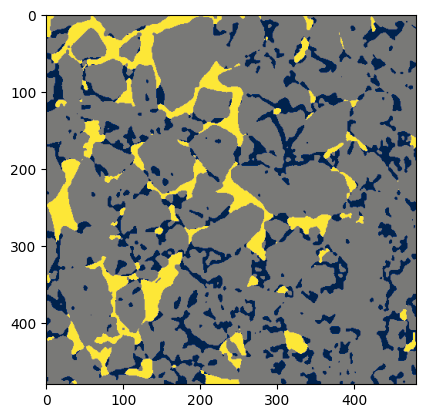

In [15]:
predict(im2, 480, weights_final, backbone='resnet34', train_transfer='imagenet', pref='None')

1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0


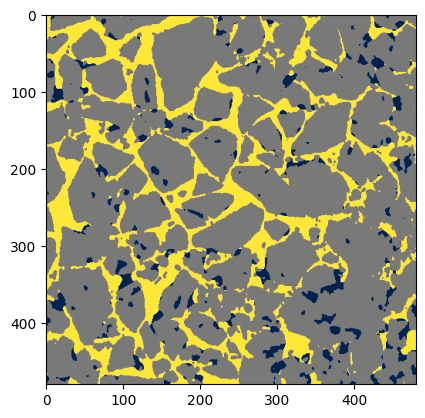

In [16]:
predict(im2, 480, weights_dropout_fold3, backbone='resnet34', train_transfer='imagenet', pref='None')

In [ ]:
# to test smooth prediction
predict(im12, 64, weights_baseline, backbone='resnet34', train_transfer='imagenet', pref='None', smooth=True)

(256, 256, 3)


  0%|          | 0/8 [00:00<?, ?it/s]

2/2 [==============================] - 10s 3s/step


 12%|█▎        | 1/8 [00:11<01:17, 11.04s/it]

2/2 [==============================] - 9s 4s/step


 25%|██▌       | 2/8 [00:21<01:04, 10.78s/it]

2/2 [==============================] - 10s 3s/step


 38%|███▊      | 3/8 [00:32<00:54, 10.87s/it]

2/2 [==============================] - 10s 3s/step


 50%|█████     | 4/8 [00:43<00:44, 11.07s/it]

2/2 [==============================] - 10s 3s/step


 62%|██████▎   | 5/8 [00:54<00:32, 10.98s/it]

2/2 [==============================] - 10s 3s/step


 75%|███████▌  | 6/8 [01:05<00:21, 10.95s/it]

2/2 [==============================] - 9s 3s/step


 88%|████████▊ | 7/8 [01:16<00:10, 10.90s/it]

2/2 [==============================] - 10s 3s/step


100%|██████████| 8/8 [01:27<00:00, 10.93s/it]


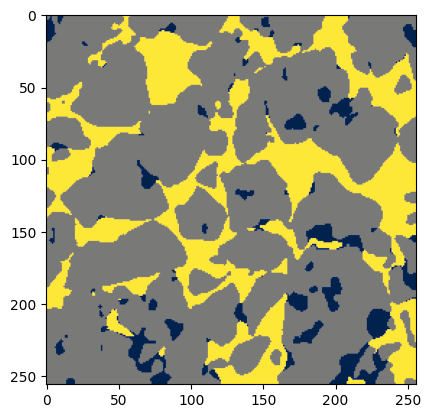

In [71]:
# to test smooth prediction
predict(im12,256, weights_baseline, backbone='resnet34', train_transfer='imagenet', pref='None', smooth=True)

(256, 256, 3)
1/1 [==============================] - 1s 1s/step
Finished processing patch number  1  at position  0 0


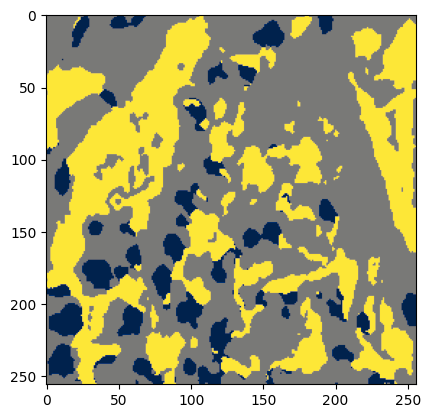

In [97]:
predict(im5, 256, weights_list[0], backbone='resnet34', train_transfer='imagenet', pref='vgg_2424')

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


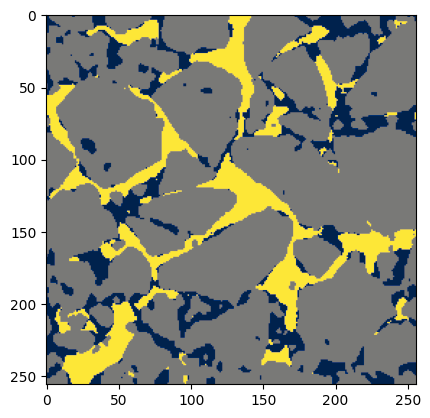

In [43]:
# random_random mode
weights_256_2 = 'weights/best_modelbaseline_256_foldn2.h5'
predict(im2, 256, weights_256_2, backbone='resnet34', train_transfer='imagenet', pref='256_fin')

1/1 [==============================] - 2s 2s/step
Finished processing patch number  1  at position  0 0


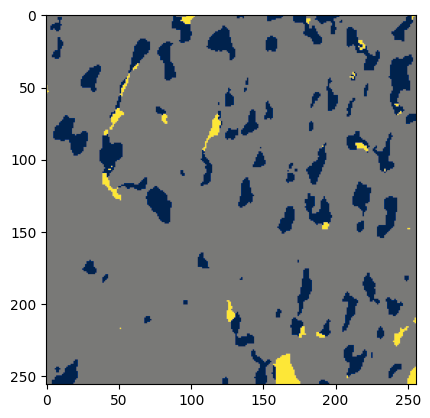

In [61]:
# slide_slide mode
weights_random = 'weights/best_modelother_patch_foldn2.h5'
predict(im6, 256, weights_random, backbone='resnet34', train_transfer='imagenet', pref='_')

(256, 256, 3)
1/1 [==============================] - 1s 1s/step
Finished processing patch number  1  at position  0 0


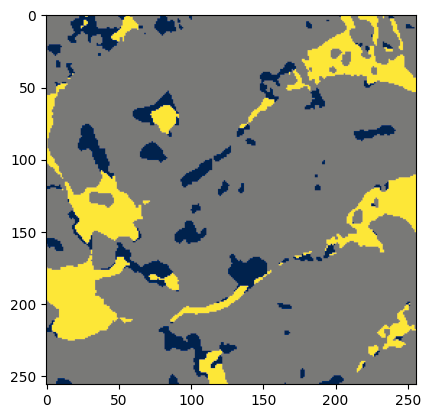

In [101]:
# random_slide mode
weights_slide = 'weights/best_modelrandom_slide_foldn4.h5'
predict(im7, 256, weights_slide, backbone='resnet34', train_transfer='imagenet', pref='_')

(256, 256, 3)
1/1 [==============================] - 3s 3s/step
Finished processing patch number  1  at position  0 0


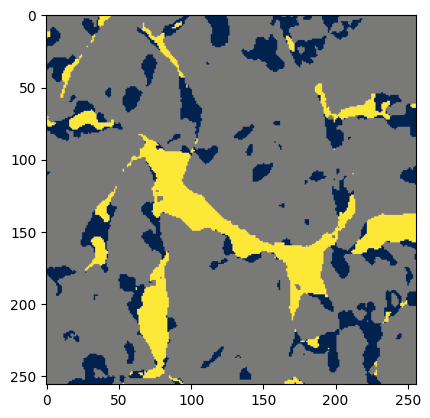

In [17]:
weights_vgg2 = 'weights/best_modelinceptionv3_long_foldn4.h5'
predict(im4, 256, weights_vgg2, backbone='inceptionv3', train_transfer='imagenet', pref='vgg_2424')